# DCGAN Workspace 1

In [68]:
from numpy import expand_dims, ones, zeros, vstack
from numpy.random import rand, randint, randn
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Conv2DTranspose, Reshape
from matplotlib import pyplot
import logging
import io
from contextlib import redirect_stdout


### Discriminator Try

First, we need to build a discriminator model. This model will take a 28X28x1 image and down sample the image to 14x14 and then to 7x7. The reason for the extra dimension is to give a space for the value of the pixel (white or black, but in a sigmoid 0 to 1 format)

In [17]:
def create_discriminator(in_shape=(28,28,1)):
    """
    Creates a discrimator model

    Input:
    in-shape: This is the shape of the photos that will be put into the discriminator model.

    Output:
    The model for discriminating fake vs real images
    """
    model =  Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

Load mnist training images and generate fake images to train discriminator

In [18]:
# Load mnist data set
def load_mnist():
    """
    This function loads the MNIST dataset, and scales it to be in a sigmoid (0, 1) range
    """
    (trainX, _), (_, _) = load_data()
    # add third dimension for color value
    X = expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = X / 255.0
    return X

# Randomly select real samples from MNIST to train with
def select_real_samples(dataset, n_samples):
    """
    Selects some number of real samples to train with from the input dataset.
    Uses random to select random images. Labels the images as 'real' with label = 1

    Inputs:
    dataset: Input dataset(MNIST)
    n_sample: number of samples to select

    Return:
    X: Selected images
    y: tags for images
    """
    # get n number of random images from dataset
    i = randint(0, dataset.shape[0], n_samples)

    X = dataset[i]
    y = ones((n_samples, 1))

    return X, y

# Create n amount of fake images to train discriminator
def initial_create_fake_samples(n_samples):
    """
    Creates fake samples to train discriminator with correct dimensions

    Input:
    n_samples: number of samples to create

    Return:
    X: fake images
    y: image tags for training, 0 to mean not real images
    """
    X = rand(28 * 28 * n_samples)

    # Reshape and add tags to show fake
    X = X.reshape((n_samples, 28, 28, 1))
    y = zeros((n_samples, 1))
    return X, y

Train Discriminator Model

In [19]:
def train_discriminator(model, dataset, iterations=100, batch_size=256):
    """
    Trains the discriminator using mnist dataset and fake images.
    Takes half batch size of real and fake for each iteration.

    Inputs:
    model: input model
    dataset: loaded dataset (MNIST)
    iterations: number of iterations of training
    batch_size: images to train with in each iteration
    """

    for i in range(iterations):
        # Select real images and train discriminator
        X_real, y_real = select_real_samples(dataset, int(batch_size / 2))
        _, real_acc = model.train_on_batch(X_real, y_real)

        # Select fake images and train discriminator
        X_fake, y_fake = initial_create_fake_samples(int(batch_size / 2))
        _, fake_acc = model.train_on_batch(X_fake, y_fake)

        #Performance
        print(f'>{i+1} real={real_acc*100:.0f}% fake={fake_acc*100:.0f}%')


model = create_discriminator()
dataset = load_mnist()
train_discriminator(model, dataset)

>1 real=26% fake=52%
>2 real=34% fake=62%
>3 real=45% fake=87%
>4 real=40% fake=98%
>5 real=49% fake=98%
>6 real=44% fake=99%
>7 real=45% fake=100%
>8 real=43% fake=100%
>9 real=48% fake=100%
>10 real=38% fake=100%
>11 real=51% fake=100%
>12 real=54% fake=100%
>13 real=59% fake=100%
>14 real=56% fake=100%
>15 real=59% fake=100%
>16 real=62% fake=100%
>17 real=73% fake=100%
>18 real=70% fake=100%
>19 real=67% fake=100%
>20 real=78% fake=100%
>21 real=77% fake=100%
>22 real=82% fake=100%
>23 real=85% fake=100%
>24 real=91% fake=100%
>25 real=94% fake=100%
>26 real=91% fake=100%
>27 real=93% fake=100%
>28 real=97% fake=100%
>29 real=96% fake=100%
>30 real=100% fake=100%
>31 real=99% fake=100%
>32 real=99% fake=100%
>33 real=98% fake=100%
>34 real=100% fake=100%
>35 real=99% fake=100%
>36 real=100% fake=100%
>37 real=100% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>40 real=100% fake=100%
>41 real=100% fake=100%
>42 real=100% fake=100%
>43 real=100% fake=100%
>44 real=100% fa

We can see above that with fake images as messy as randomly generated images along with real images from the mnist data set, we didn't need that many iterations or very big batch size to create a discriminator which could detect fakes pretty well.

### Generator Model

Create the Generator Model



In [20]:
def create_generator(latent_dim):
    """
    Creates a generator model.
    Starts with a 7x7 and reshapes to be 14x14 then 28x28.

    Input:
    latent-dim: Dimension of the latent space

    Return:
    The generator model
    """

    model = Sequential()
    n_nodes = 128 * 7 * 7

    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))

    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))

    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

Generate latent points and fake samples

In [21]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    """
    Generates points in latent space.
    Used as input for the generator

    Inputs:
    latent_dim: Dimension of the latent space
    n_samples: number of samples to generate

    Return:
    x_input: points in latent space
    """
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def create_fake_samples(g_model, latent_dim, n_samples):
    """
    Generates fake samples from the generator model.
    Creates labels of 0 for the fake images

    Inputs:
    g_model: generator model
    latent_dim: Dimension of the latent space
    n_samples: number of samples to generate

    Return:
    X: fake images
    y: image tags for training, 0 to mean not real
    """
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

Test the generation of fake samples

1/1 [==============================] - 0s 106ms/step


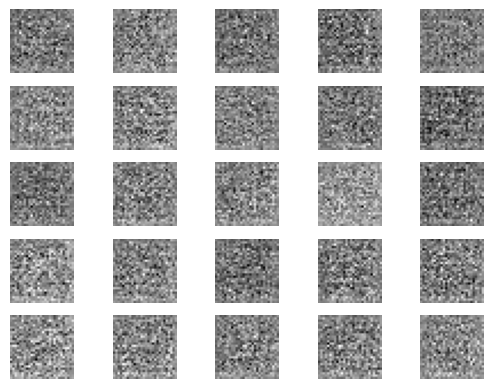

In [22]:
latent_dim = 100

model = create_generator(latent_dim)

n_samples = 25
X, _ = create_fake_samples(model, latent_dim, n_samples)

# 5 x 5 plot of generated samples
for i in range(n_samples):
    pyplot.subplot(5, 5, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X[i, :, :, 0], cmap='gray_r')

pyplot.show()

Training the Generator Model

While we want to train the generator model so it generates images that are closer to the mnist dataset, we dont want to incorrectly train the detection model.

We will create one model using the two other models which allows the generator to be trained, but the detection model is untrainable.

In [23]:
def create_gan(g_model, d_model):
    """
    Creating the GAN model. The generator is trained but the discriminator is untrainable.

    Inputs:
    g_model: generator model
    d_model: discriminator model

    Return:
    The GAN model
    """
    d_model.trainable = False

    model = Sequential()
    model.add(g_model)
    model.add(d_model)

    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

Train the GAN model

In [33]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    """
    Trains the generator and discriminator.

    Inputs:
    g_model: generator model
    d_model: discriminator model
    gan_model: GAN model
    dataset: MNIST dataset
    latent_dim: Dimension of the latent space
    n_epochs: number of epochs to train
    n_batch: number of images to train with in each iteration
    """
    num_batch = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):

        for j in range(num_batch):
            # generate real and fake samples
            X_real, y_real = select_real_samples(dataset, half_batch)
            X_fake, y_fake = create_fake_samples(g_model, latent_dim, half_batch)

            # train discriminator separately
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)

            # train generator - use 1 value to find how often it is wrong to update model
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))

            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            print(f'>{i+1}, {j+1}/{num_batch}, d={d_loss:.3f}, g={g_loss:.3f}')

        if (i+1) % 10 == 0:
            performance_summary(i, g_model, d_model, dataset, latent_dim)

Create some way to track the performance, and also save the generator model weights every 10 epochs

In [58]:
def create_plot(examples, epoch, n=10):
    """
    Creates a physical picture to look at to see how the training is coming after each 10 epochs

    Inputs:
    examples: images to plot
    epoch: epoch number
    n: number of images to plot
    """
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()


def performance_summary(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    """
    Every 10 epochs, save a copy of the model as well as a plot of generated images.

    Inputs:
    epoch: epoch number
    g_model: generator model
    d_model: discriminator model
    dataset: MNIST dataset
    latent_dim: Dimension of the latent space
    n_samples: number of samples to generate
    """
    # take real samples and evaluate discriminator
    X_real, y_real = select_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

    # take generated samples and evaluate using discriminator
    x_fake, y_fake = create_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

    # summarize discriminator performance
    print(f'>Accuracy real: {acc_real*100:.0f}%, fake: {acc_fake*100:.0f}%')
    logger.info(f'>Accuracy real: {acc_real*100:.0f}%, fake: {acc_fake*100:.0f}%')

    # create the 10 x 10 plot picture
    create_plot(x_fake, epoch)

    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

In [26]:
# load and prepare mnist training images
def load_real_samples():
    """
    Loads the MNIST dataset and scales it to be in a sigmoid (0, 1) range
    """
    (trainX, _), (_, _) = load_data()
    X = expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = X / 255.0
    return X


Create a logger for Hyperparameters and Training data


In [63]:
def initialize_logger():
    """
    Creates a logger for hyperparameters and training data.
    """
    # Get the name of the current script
    script_name = 'dcgan_base'
    log_filename = f'{script_name}.log'

    # Create a custom logger
    logger = logging.getLogger(script_name)
    logger.setLevel(logging.DEBUG)

    # Create handlers
    c_handler = logging.StreamHandler()
    f_handler = logging.FileHandler(log_filename)
    c_handler.setLevel(logging.INFO)
    f_handler.setLevel(logging.DEBUG)

    # Create formatters and add it to handlers
    c_format = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
    f_format = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    c_handler.setFormatter(c_format)
    f_handler.setFormatter(f_format)

    # Add handlers to the logger
    logger.addHandler(c_handler)
    logger.addHandler(f_handler)

    return logger

In [69]:
def log_model_summary(model, logger):
    with io.StringIO() as buf, redirect_stdout(buf):
        model.summary()
        summary = buf.getvalue()
    logger.info(summary)

Finally, train the whole model

In [71]:
logger = initialize_logger()
logger.info('Program started')
logger.info('------------------------------------------------------------')

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = create_discriminator()
logger.info('Discriminator created')
log_model_summary(d_model, logger)
logger.info('------------------------------------------------------------')
# create the generator
g_model = create_generator(latent_dim)
logger.info('Generator created')
log_model_summary(g_model, logger)
logger.info('------------------------------------------------------------')
# create the gan
gan_model = create_gan(g_model, d_model)
logger.info('GAN created')
log_model_summary(gan_model, logger)
logger.info('------------------------------------------------------------')
# load image data
dataset = load_real_samples()
# train model
logger.info('Training started')
train(g_model, d_model, gan_model, dataset, latent_dim)

dcgan_base - INFO - Program started
dcgan_base - INFO - Program started
dcgan_base - INFO - Program started
dcgan_base - INFO - Program started
INFO:dcgan_base:Program started
dcgan_base - INFO - ------------------------------------------------------------
dcgan_base - INFO - ------------------------------------------------------------
dcgan_base - INFO - ------------------------------------------------------------
dcgan_base - INFO - ------------------------------------------------------------
INFO:dcgan_base:------------------------------------------------------------
dcgan_base - INFO - Discriminator created
dcgan_base - INFO - Discriminator created
dcgan_base - INFO - Discriminator created
dcgan_base - INFO - Discriminator created
INFO:dcgan_base:Discriminator created
dcgan_base - INFO - Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 14, 14

4/4 [==============================] - 0s 2ms/step
>1, 1/234, d=0.673, g=0.741
4/4 [==============================] - 0s 2ms/step
>1, 2/234, d=0.673, g=0.759
4/4 [==============================] - 0s 2ms/step
>1, 3/234, d=0.659, g=0.778
4/4 [==============================] - 0s 2ms/step
>1, 4/234, d=0.656, g=0.788
4/4 [==============================] - 0s 2ms/step
>1, 5/234, d=0.648, g=0.802
4/4 [==============================] - 0s 2ms/step
>1, 6/234, d=0.645, g=0.824
4/4 [==============================] - 0s 2ms/step
>1, 7/234, d=0.638, g=0.830
4/4 [==============================] - 0s 2ms/step
>1, 8/234, d=0.634, g=0.838
4/4 [==============================] - 0s 2ms/step
>1, 9/234, d=0.629, g=0.844
4/4 [==============================] - 0s 2ms/step
>1, 10/234, d=0.626, g=0.840
4/4 [==============================] - 0s 2ms/step
>1, 11/234, d=0.627, g=0.827
4/4 [==============================] - 0s 2ms/step
>1, 12/234, d=0.627, g=0.815
4/4 [==============================] - 0s 2ms/ste

dcgan_base - INFO - >Accuracy real: 57%, fake: 71%
dcgan_base - INFO - >Accuracy real: 57%, fake: 71%
dcgan_base - INFO - >Accuracy real: 57%, fake: 71%
dcgan_base - INFO - >Accuracy real: 57%, fake: 71%
INFO:dcgan_base:>Accuracy real: 57%, fake: 71%


>Accuracy real: 57%, fake: 71%


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 2ms/step
>11, 1/234, d=0.691, g=0.715
4/4 [==============================] - 0s 2ms/step
>11, 2/234, d=0.691, g=0.706
4/4 [==============================] - 0s 2ms/step
>11, 3/234, d=0.689, g=0.712
4/4 [==============================] - 0s 2ms/step
>11, 4/234, d=0.688, g=0.704
4/4 [==============================] - 0s 2ms/step
>11, 5/234, d=0.688, g=0.702
4/4 [==============================] - 0s 2ms/step
>11, 6/234, d=0.687, g=0.699
4/4 [==============================] - 0s 2ms/step
>11, 7/234, d=0.694, g=0.691
4/4 [==============================] - 0s 2ms/step
>11, 8/234, d=0.688, g=0.688
4/4 [==============================] - 0s 2ms/step
>11, 9/234, d=0.683, g=0.697
4/4 [==============================] - 0s 2ms/step
>11, 10/234, d=0.689, g=0.703
4/4 [==============================] - 0s 2ms/step
>11, 11/234, d=0.692, g=0.718
4/4 [==============================] - 0s 2ms/step
>11, 12/234, d=0.687, g=0.717
4/4 [==============================] 

dcgan_base - INFO - >Accuracy real: 50%, fake: 88%
dcgan_base - INFO - >Accuracy real: 50%, fake: 88%
dcgan_base - INFO - >Accuracy real: 50%, fake: 88%
dcgan_base - INFO - >Accuracy real: 50%, fake: 88%
INFO:dcgan_base:>Accuracy real: 50%, fake: 88%


>Accuracy real: 50%, fake: 88%


4/4 [==============================] - 0s 2ms/step
>21, 1/234, d=0.689, g=0.704
4/4 [==============================] - 0s 2ms/step
>21, 2/234, d=0.685, g=0.708
4/4 [==============================] - 0s 2ms/step
>21, 3/234, d=0.690, g=0.715
4/4 [==============================] - 0s 2ms/step
>21, 4/234, d=0.679, g=0.709
4/4 [==============================] - 0s 2ms/step
>21, 5/234, d=0.684, g=0.709
4/4 [==============================] - 0s 2ms/step
>21, 6/234, d=0.686, g=0.699
4/4 [==============================] - 0s 2ms/step
>21, 7/234, d=0.683, g=0.690
4/4 [==============================] - 0s 2ms/step
>21, 8/234, d=0.690, g=0.694
4/4 [==============================] - 0s 2ms/step
>21, 9/234, d=0.682, g=0.700
4/4 [==============================] - 0s 2ms/step
>21, 10/234, d=0.686, g=0.704
4/4 [==============================] - 0s 3ms/step
>21, 11/234, d=0.684, g=0.714
4/4 [==============================] - 0s 2ms/step
>21, 12/234, d=0.685, g=0.709
4/4 [==============================] 

dcgan_base - INFO - >Accuracy real: 92%, fake: 36%
dcgan_base - INFO - >Accuracy real: 92%, fake: 36%
dcgan_base - INFO - >Accuracy real: 92%, fake: 36%
dcgan_base - INFO - >Accuracy real: 92%, fake: 36%
INFO:dcgan_base:>Accuracy real: 92%, fake: 36%


>Accuracy real: 92%, fake: 36%


4/4 [==============================] - 0s 2ms/step
>31, 1/234, d=0.686, g=0.690
4/4 [==============================] - 0s 2ms/step
>31, 2/234, d=0.688, g=0.684
4/4 [==============================] - 0s 2ms/step
>31, 3/234, d=0.678, g=0.683
4/4 [==============================] - 0s 2ms/step
>31, 4/234, d=0.687, g=0.699
4/4 [==============================] - 0s 2ms/step
>31, 5/234, d=0.678, g=0.723
4/4 [==============================] - 0s 2ms/step
>31, 6/234, d=0.681, g=0.738
4/4 [==============================] - 0s 2ms/step
>31, 7/234, d=0.679, g=0.745
4/4 [==============================] - 0s 2ms/step
>31, 8/234, d=0.692, g=0.732
4/4 [==============================] - 0s 2ms/step
>31, 9/234, d=0.684, g=0.729
4/4 [==============================] - 0s 2ms/step
>31, 10/234, d=0.684, g=0.710
4/4 [==============================] - 0s 2ms/step
>31, 11/234, d=0.685, g=0.696
4/4 [==============================] - 0s 2ms/step
>31, 12/234, d=0.690, g=0.689
4/4 [==============================] 

dcgan_base - INFO - >Accuracy real: 14%, fake: 99%
dcgan_base - INFO - >Accuracy real: 14%, fake: 99%
dcgan_base - INFO - >Accuracy real: 14%, fake: 99%
dcgan_base - INFO - >Accuracy real: 14%, fake: 99%
INFO:dcgan_base:>Accuracy real: 14%, fake: 99%


>Accuracy real: 14%, fake: 99%


4/4 [==============================] - 0s 2ms/step
>41, 1/234, d=0.692, g=0.736
4/4 [==============================] - 0s 2ms/step
>41, 2/234, d=0.684, g=0.724
4/4 [==============================] - 0s 2ms/step
>41, 3/234, d=0.694, g=0.704
4/4 [==============================] - 0s 2ms/step
>41, 4/234, d=0.683, g=0.710
4/4 [==============================] - 0s 2ms/step
>41, 5/234, d=0.684, g=0.702
4/4 [==============================] - 0s 2ms/step
>41, 6/234, d=0.677, g=0.720
4/4 [==============================] - 0s 2ms/step
>41, 7/234, d=0.679, g=0.736
4/4 [==============================] - 0s 2ms/step
>41, 8/234, d=0.692, g=0.716
4/4 [==============================] - 0s 2ms/step
>41, 9/234, d=0.689, g=0.680
4/4 [==============================] - 0s 2ms/step
>41, 10/234, d=0.690, g=0.665
4/4 [==============================] - 0s 2ms/step
>41, 11/234, d=0.679, g=0.669
4/4 [==============================] - 0s 2ms/step
>41, 12/234, d=0.682, g=0.716
4/4 [==============================] 

dcgan_base - INFO - >Accuracy real: 38%, fake: 84%
dcgan_base - INFO - >Accuracy real: 38%, fake: 84%
dcgan_base - INFO - >Accuracy real: 38%, fake: 84%
dcgan_base - INFO - >Accuracy real: 38%, fake: 84%
INFO:dcgan_base:>Accuracy real: 38%, fake: 84%


>Accuracy real: 38%, fake: 84%


4/4 [==============================] - 0s 2ms/step
>51, 1/234, d=0.680, g=0.715
4/4 [==============================] - 0s 2ms/step
>51, 2/234, d=0.689, g=0.698
4/4 [==============================] - 0s 2ms/step
>51, 3/234, d=0.691, g=0.705
4/4 [==============================] - 0s 2ms/step
>51, 4/234, d=0.685, g=0.708
4/4 [==============================] - 0s 2ms/step
>51, 5/234, d=0.678, g=0.702
4/4 [==============================] - 0s 2ms/step
>51, 6/234, d=0.684, g=0.700
4/4 [==============================] - 0s 2ms/step
>51, 7/234, d=0.694, g=0.707
4/4 [==============================] - 0s 2ms/step
>51, 8/234, d=0.683, g=0.706
4/4 [==============================] - 0s 2ms/step
>51, 9/234, d=0.685, g=0.706
4/4 [==============================] - 0s 2ms/step
>51, 10/234, d=0.697, g=0.707
4/4 [==============================] - 0s 2ms/step
>51, 11/234, d=0.693, g=0.724
4/4 [==============================] - 0s 2ms/step
>51, 12/234, d=0.695, g=0.720
4/4 [==============================] 

dcgan_base - INFO - >Accuracy real: 22%, fake: 92%
dcgan_base - INFO - >Accuracy real: 22%, fake: 92%
dcgan_base - INFO - >Accuracy real: 22%, fake: 92%
dcgan_base - INFO - >Accuracy real: 22%, fake: 92%
INFO:dcgan_base:>Accuracy real: 22%, fake: 92%


>Accuracy real: 22%, fake: 92%


4/4 [==============================] - 0s 2ms/step
>61, 1/234, d=0.686, g=0.702
4/4 [==============================] - 0s 2ms/step
>61, 2/234, d=0.695, g=0.689
4/4 [==============================] - 0s 2ms/step
>61, 3/234, d=0.684, g=0.699
4/4 [==============================] - 0s 2ms/step
>61, 4/234, d=0.693, g=0.691
4/4 [==============================] - 0s 2ms/step
>61, 5/234, d=0.685, g=0.680
4/4 [==============================] - 0s 2ms/step
>61, 6/234, d=0.695, g=0.692
4/4 [==============================] - 0s 2ms/step
>61, 7/234, d=0.693, g=0.731
4/4 [==============================] - 0s 2ms/step
>61, 8/234, d=0.684, g=0.724
4/4 [==============================] - 0s 2ms/step
>61, 9/234, d=0.691, g=0.690
4/4 [==============================] - 0s 2ms/step
>61, 10/234, d=0.700, g=0.679
4/4 [==============================] - 0s 2ms/step
>61, 11/234, d=0.696, g=0.697
4/4 [==============================] - 0s 2ms/step
>61, 12/234, d=0.684, g=0.730
4/4 [==============================] 

dcgan_base - INFO - >Accuracy real: 5%, fake: 100%
dcgan_base - INFO - >Accuracy real: 5%, fake: 100%
dcgan_base - INFO - >Accuracy real: 5%, fake: 100%
dcgan_base - INFO - >Accuracy real: 5%, fake: 100%
INFO:dcgan_base:>Accuracy real: 5%, fake: 100%


>Accuracy real: 5%, fake: 100%


4/4 [==============================] - 0s 2ms/step
>71, 1/234, d=0.689, g=0.697
4/4 [==============================] - 0s 2ms/step
>71, 2/234, d=0.698, g=0.667
4/4 [==============================] - 0s 2ms/step
>71, 3/234, d=0.691, g=0.704
4/4 [==============================] - 0s 2ms/step
>71, 4/234, d=0.684, g=0.714
4/4 [==============================] - 0s 2ms/step
>71, 5/234, d=0.688, g=0.723
4/4 [==============================] - 0s 2ms/step
>71, 6/234, d=0.688, g=0.714
4/4 [==============================] - 0s 2ms/step
>71, 7/234, d=0.695, g=0.708
4/4 [==============================] - 0s 2ms/step
>71, 8/234, d=0.690, g=0.712
4/4 [==============================] - 0s 2ms/step
>71, 9/234, d=0.690, g=0.703
4/4 [==============================] - 0s 2ms/step
>71, 10/234, d=0.689, g=0.692
4/4 [==============================] - 0s 2ms/step
>71, 11/234, d=0.694, g=0.686
4/4 [==============================] - 0s 2ms/step
>71, 12/234, d=0.693, g=0.682
4/4 [==============================] 

dcgan_base - INFO - >Accuracy real: 15%, fake: 95%
dcgan_base - INFO - >Accuracy real: 15%, fake: 95%
dcgan_base - INFO - >Accuracy real: 15%, fake: 95%
dcgan_base - INFO - >Accuracy real: 15%, fake: 95%
INFO:dcgan_base:>Accuracy real: 15%, fake: 95%


>Accuracy real: 15%, fake: 95%


4/4 [==============================] - 0s 2ms/step
>81, 1/234, d=0.696, g=0.716
4/4 [==============================] - 0s 2ms/step
>81, 2/234, d=0.698, g=0.713
4/4 [==============================] - 0s 2ms/step
>81, 3/234, d=0.687, g=0.689
4/4 [==============================] - 0s 2ms/step
>81, 4/234, d=0.693, g=0.694
4/4 [==============================] - 0s 2ms/step
>81, 5/234, d=0.690, g=0.711
4/4 [==============================] - 0s 2ms/step
>81, 6/234, d=0.689, g=0.715
4/4 [==============================] - 0s 2ms/step
>81, 7/234, d=0.695, g=0.708
4/4 [==============================] - 0s 2ms/step
>81, 8/234, d=0.685, g=0.703
4/4 [==============================] - 0s 2ms/step
>81, 9/234, d=0.693, g=0.706
4/4 [==============================] - 0s 2ms/step
>81, 10/234, d=0.686, g=0.708
4/4 [==============================] - 0s 2ms/step
>81, 11/234, d=0.694, g=0.692
4/4 [==============================] - 0s 2ms/step
>81, 12/234, d=0.693, g=0.705
4/4 [==============================] 

dcgan_base - INFO - >Accuracy real: 29%, fake: 90%
dcgan_base - INFO - >Accuracy real: 29%, fake: 90%
dcgan_base - INFO - >Accuracy real: 29%, fake: 90%
dcgan_base - INFO - >Accuracy real: 29%, fake: 90%
INFO:dcgan_base:>Accuracy real: 29%, fake: 90%


>Accuracy real: 29%, fake: 90%


4/4 [==============================] - 0s 2ms/step
>91, 1/234, d=0.686, g=0.718
4/4 [==============================] - 0s 2ms/step
>91, 2/234, d=0.690, g=0.707
4/4 [==============================] - 0s 2ms/step
>91, 3/234, d=0.696, g=0.698
4/4 [==============================] - 0s 2ms/step
>91, 4/234, d=0.693, g=0.691
4/4 [==============================] - 0s 2ms/step
>91, 5/234, d=0.687, g=0.702
4/4 [==============================] - 0s 2ms/step
>91, 6/234, d=0.682, g=0.712
4/4 [==============================] - 0s 3ms/step
>91, 7/234, d=0.682, g=0.717
4/4 [==============================] - 0s 2ms/step
>91, 8/234, d=0.681, g=0.711
4/4 [==============================] - 0s 2ms/step
>91, 9/234, d=0.688, g=0.695
4/4 [==============================] - 0s 2ms/step
>91, 10/234, d=0.682, g=0.678
4/4 [==============================] - 0s 2ms/step
>91, 11/234, d=0.693, g=0.689
4/4 [==============================] - 0s 2ms/step
>91, 12/234, d=0.688, g=0.701
4/4 [==============================] 

dcgan_base - INFO - >Accuracy real: 6%, fake: 98%
dcgan_base - INFO - >Accuracy real: 6%, fake: 98%
dcgan_base - INFO - >Accuracy real: 6%, fake: 98%
dcgan_base - INFO - >Accuracy real: 6%, fake: 98%
INFO:dcgan_base:>Accuracy real: 6%, fake: 98%


>Accuracy real: 6%, fake: 98%


In [ ]:
import tensorflow as tf
import keras

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.15.0
Keras version: 2.15.0
